# Near detuned lattice transport simulations

Santi

23 January 2026

The goal here is to simulate the near detuned lattice transport at various detunings from the D1 and D2 lines of Cs and Rb.

The process will be to sweep the beam focus and waist to find the optimal parameters for each detuning wavelength at a fixed power of 1W.
Additionally, at each of these detunings, we will need to calculate the scattering rate, and then the heating rate.

In [1]:
from get_polarizability import *

import matplotlib.pyplot as plt
import numpy as np


# ARC (install with: pip install ARC-Alkali-Rydberg-Calculator)
from arc import PairStateInteractions, AlkaliAtom  # species and interactions'
# import all the atoms we might use
from arc import Sodium, Cesium, Rubidium, Potassium

In [ ]:
# constants
h = 6.62607015e-34  # Planck's constant in J*s
hbar = h / (2 * np.pi)  # reduced Planck's constant
c = 299792458  # speed of light in m/s
epsilon_0 = 8.854187817e-12  # vacuum permittivity in F/m
a0 = 5.29177210903e-11  # Bohr radius in meters
e = 1.602176634e-19  # elementary charge in Coulombs
me = 9.10938356e-31  # electron mass in kg
kB = 1.380649e-23  # Boltzmann constant in J/K

Cs_D1_wavelength = 894.592959e-9  # Cs D1 line wavelength in meters
Rb_D1_wavelength = 794.978850e-9      # Rb D1 line wavelength in meters

Cs_D2_wavelength = 852.34727582e-9  # Cs D2 line wavelength in meters
Rb_D2_wavelength = 780.241209686e-9  # Rb

## Define useful functions for calculating trap depths

In [3]:
def odt_depth(I, alpha):
    """ calculate ODT depth in Kelvin"""
    U = -0.5 * alpha * I / (c * epsilon_0)  # in Joules
    return -U / kB

def Gaussian_beam_size(w0, x, xf, xR):
    """ calculate Gaussian beam size at position x"""
    w_x = w0 * np.sqrt(1 + ((x - xf)/ xR)**2)
    # # plot beam size as a function of distance from focus
    # plt.figure()
    # plt.plot(x - xf, w_x, 'k-', label='Beam Size')
    # plt.xlabel('Distance from Focus (m)')
    # plt.ylabel('Beam Size (m)')
    # plt.axvline(x=0, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return w_x

def Gaussian_beam_peak_intensity(P, w, xf, x):
    """ calculate Gaussian beam peak intensity with beam size w"""
    intensity = 2 * P / (np.pi * w**2) # peak intensity
    # # plot intensity profile
    # plt.figure()
    # plt.plot(x, intensity, 'k-', label='Intensity Profile')
    # plt.xlabel('Position (m)')
    # plt.ylabel('Intensity (W/m^2)')
    # plt.axvline(x=xf, color='r', linestyle='--', label='Focus Position')
    # plt.legend()
    # plt.show()
    return intensity

def Gaussian_beam_intensity(P, w0, pos_array, xf, wavelength):
    """ calculate Gaussian beam intensity as a function of x,y,z focused at a point xf"""
    xR = np.pi * w0**2 / wavelength  # Rayleigh range
    w_x = Gaussian_beam_size(w0, pos_array[0], xf, xR) # position dependent beam size
    I_xyz = Gaussian_beam_peak_intensity(P, w_x, xf, pos_array[0]) * np.exp(-2 * (pos_array[1]**2 + pos_array[2]**2) / w_x**2)
    return I_xyz

def two_beam_lattice_intensity(P, w0, pos_array, focus1, focus2):
    """ calculate two-beam lattice intensity as a function of x,y,z"""
    I1 = Gaussian_beam_intensity(P, w0, pos_array, focus1)
    I2 = Gaussian_beam_intensity(P, w0, pos_array, focus2)
    I_lattice = I1 + I2 + 2 * np.sqrt(I1 * I2) * np.cos(4 * np.pi * pos_array[0] / wavelength)
    return I_lattice

In [12]:
# function to calculate wavelength range from frequency range from D1 and D2 lines of an atom
def wavelength_range_from_D_lines(atom="Rb", line="D1", freq_range=500):
    """
    Function returns minimum and maximum wavelength (in nm) from the D1 or D2 line of the specified atom at a given frequency range (in GHz).
    Args:
        atom (str): "Rb" or "Cs"
        line (str): "D1" or "D2"
        freq_range (float): frequency range in GHz
    Returns:
        tuple: (min_wavelength_nm, max_wavelength_nm)
    """
    if atom == "Rb":
        if line == "D1":
            center_freq = 377.107463380  # THz
        elif line == "D2":
            center_freq = 384.230484468  # THz
        else:
            raise ValueError("Line must be 'D1' or 'D2'")
    elif atom == "Cs":
        if line == "D1":
            center_freq = 335.116048884  # THz
        elif line == "D2":
            center_freq = 351.725718500  # THz
        else:
            raise ValueError("Line must be 'D1' or 'D2'")
    else:
        raise ValueError("Atom must be 'Rb' or 'Cs'")
    
    freq_min = center_freq - freq_range * 1e-3  # convert GHz to THz
    freq_max = center_freq + freq_range * 1e-3  # convert GHz to THz
    
    min_wavelength_nm = (c / (freq_max * 1e12)) * 1e9  # convert to nm
    max_wavelength_nm = (c / (freq_min * 1e12)) * 1e9  # convert to nm
    
    return (min_wavelength_nm, max_wavelength_nm)

# function to convert wavelength + frequency offset (in GHz) to wavelength
def wavelength_plus_freq_offset(wavelength, offset):
    """ convert wavelength + frequency offset (in GHz) to wavelength"""
    freq = c / wavelength  # in Hz
    freq_offset = offset * 1e9  # convert GHz to Hz
    new_freq = freq + freq_offset
    new_wavelength = c / new_freq
    return new_wavelength

### Quick test to see if functions work.

Wavelength for Cs: 895.9297044450028 nm
D1 line wavelength for Cs: 894.592959 nm
Cs polarizability at 895.93 nm: 47048.28 a0^3


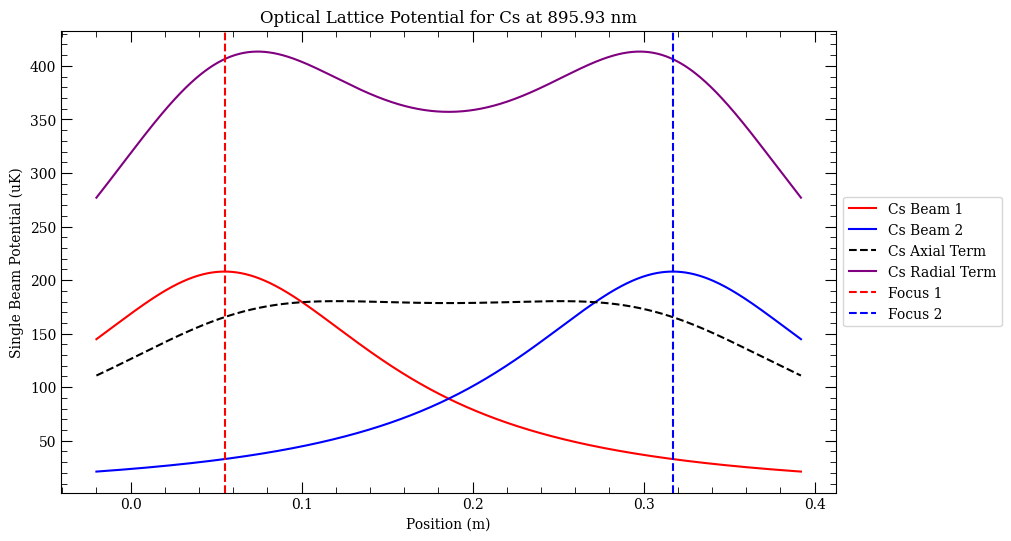

Wavelength for Rb: 795.4006929859228 nm
D1 line wavelength for Rb: 794.9788500000001 nm
Rb polarizability at 795.40 nm: 103770.65 a0^3


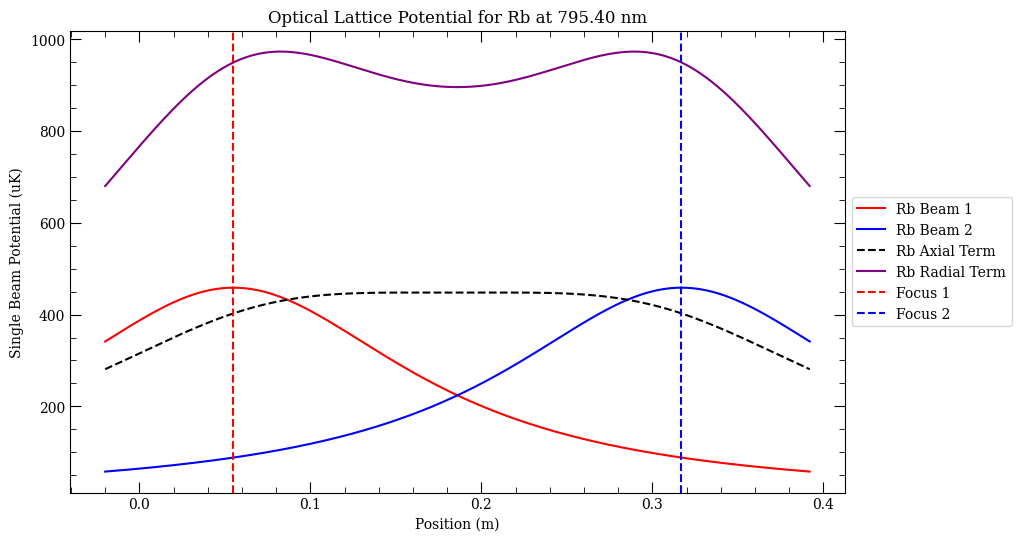

In [ ]:
power = 1 # power per beam in Watts
waist = 180e-6 # beam waist in meters
focus1 = 0.055
focus2 = 0.372-0.055

pos_array = np.array((np.linspace(focus1 - 0.075, focus2 + 0.075, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions
                    
# Cs first
wavelength_Cs = wavelength_plus_freq_offset(Cs_D1_wavelength, -500)  # Cs red detuned 200 GHz from D1
print(f"Wavelength for Cs: {wavelength_Cs*1e9} nm")
print(f"D1 line wavelength for Cs: {Cs_D1_wavelength*1e9} nm")
alpha_Cs = get_polarizability(wavelength_Cs*1e9, "Cs") * a0**3  # Cs polarizability in atomic units
print(f"Cs polarizability at {wavelength_Cs*1e9:.2f} nm: {alpha_Cs/a0**3:.2f} a0^3")
# convert polarizability from atomic units to SI units
alpha_Cs_SI = alpha_Cs * 4*np.pi * epsilon_0

I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength_Cs)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength_Cs)

# first calculate the potential created by each beam separately
U1_Cs = odt_depth(I1, alpha_Cs_SI) * 1e6  # convert to uK
U2_Cs = odt_depth(I2, alpha_Cs_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Cs = odt_depth(np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Cs, 'r-', label='Cs Beam 1')
plt.plot(pos_array[0], U2_Cs, 'b-', label='Cs Beam 2')
plt.plot(pos_array[0], 2*U_cross_Cs, 'k--', label='Cs Axial Term')
plt.plot(pos_array[0], U_radial_Cs, 'purple', label='Cs Radial Term')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Optical Lattice Potential for Cs at {wavelength_Cs*1e9:.2f} nm')
plt.show()

# repeat for Rb
wavelength_Rb = wavelength_plus_freq_offset(Rb_D1_wavelength, -200)  # Rb red detuned 200 GHz from D1
print(f"Wavelength for Rb: {wavelength_Rb*1e9} nm")
print(f"D1 line wavelength for Rb: {Rb_D1_wavelength*1e9} nm")
alpha_Rb = get_polarizability(wavelength_Rb*1e9, "Rb") * a0**3  # Rb polarizability in atomic units
print(f"Rb polarizability at {wavelength_Rb*1e9:.2f} nm: {alpha_Rb/a0**3:.2f} a0^3")
alpha_Rb_SI = alpha_Rb * 4*np.pi * epsilon_0

I1 = Gaussian_beam_intensity(power, waist, pos_array, focus1, wavelength_Rb)
I2 = Gaussian_beam_intensity(power, waist, pos_array, focus2, wavelength_Rb)

U1_Rb = odt_depth(I1, alpha_Rb_SI) * 1e6  # convert to uK
U2_Rb = odt_depth(I2, alpha_Rb_SI) * 1e6  # convert to uK
# calculate the cross term potential (axial)
U_cross_Rb = odt_depth(np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
# calculate the radial potential
U_radial_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK

plt.figure(figsize=(10, 6))
plt.plot(pos_array[0], U1_Rb, 'r-', label='Rb Beam 1')
plt.plot(pos_array[0], U2_Rb, 'b-', label='Rb Beam 2')
plt.plot(pos_array[0], 2*U_cross_Rb, 'k--', label='Rb Axial Term')
plt.plot(pos_array[0], U_radial_Rb, 'purple', label='Rb Radial Term')
# plot the positions of the foci
plt.axvline(focus1, color='red', linestyle='--', label='Focus 1')
plt.axvline(focus2, color='blue', linestyle='--', label='Focus 2')
plt.xlabel('Position (m)')
plt.ylabel('Single Beam Potential (uK)')
# put legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Optical Lattice Potential for Rb at {wavelength_Rb*1e9:.2f} nm')
plt.show()

## Perform optimization of beam foci and waists.

In [21]:
# set the wavelength and polarizabilities for both species
# Cs first
wavelength_Cs = wavelength_plus_freq_offset(Cs_D1_wavelength, -500)  # detuned from D1
print(f"Wavelength for Cs: {wavelength_Cs*1e9} nm")
print(f"D1 line wavelength for Cs: {Cs_D1_wavelength*1e9} nm")
alpha_Cs = get_polarizability(wavelength_Cs*1e9, "Cs") * a0**3  # Cs polarizability in atomic units
print(f"Cs polarizability at {wavelength_Cs*1e9:.2f} nm: {alpha_Cs/a0**3:.2f} a0^3")
# convert polarizability from atomic units to SI units
alpha_Cs_SI = alpha_Cs * 4*np.pi * epsilon_0

# Rb next
wavelength_Rb = wavelength_plus_freq_offset(Rb_D1_wavelength, -500)  # detuned from D1
print(f"Wavelength for Rb: {wavelength_Rb*1e9} nm")
print(f"D1 line wavelength for Rb: {Rb_D1_wavelength*1e9} nm")
alpha_Rb = get_polarizability(wavelength_Rb*1e9, "Rb") * a0**3  # Rb polarizability in atomic units
print(f"Rb polarizability at {wavelength_Rb*1e9:.2f} nm: {alpha_Rb/a0**3:.2f} a0^3")
alpha_Rb_SI = alpha_Rb * 4*np.pi * epsilon_0

Wavelength for Cs: 895.9297044450028 nm
D1 line wavelength for Cs: 894.592959 nm
Cs polarizability at 895.93 nm: 47048.28 a0^3
Wavelength for Rb: 796.0342975496956 nm
D1 line wavelength for Rb: 794.9788500000001 nm
Rb polarizability at 796.03 nm: 44658.62 a0^3


Optimal parameters for Cs: Waist = 163.73 microns, Focus = 0.0529 m, Max Trap Depth = 334.66 uK
Optimal parameters for Rb: Waist = 155.31 microns, Focus = 0.0526 m, Max Trap Depth = 357.40 uK


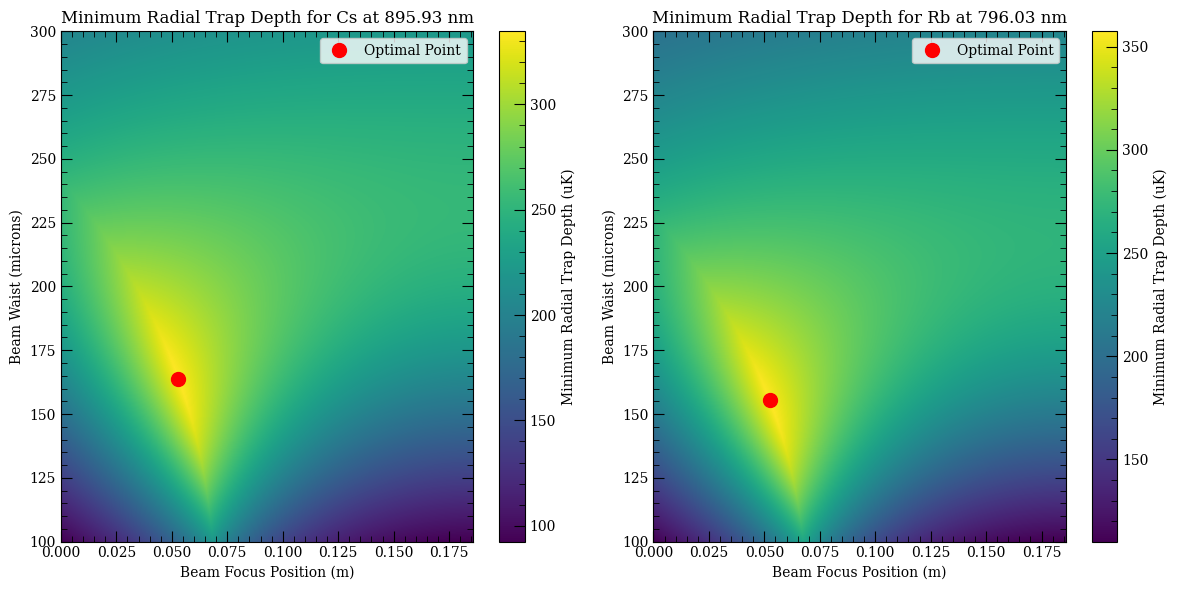

In [25]:
# now 2D sweep of beam waist and beam focus positions
# the start and stop of the atoms is always 0.0 and 0.372
# the focus positions will always be symmetric around the center point 0.186
start_pos = 0.0
stop_pos = 0.372
power = 1 # power per beam in Watts
center_pos = (start_pos + stop_pos) / 2
focus_array = np.linspace(0.0, center_pos, 500)  # focus positions from 0 to center position

waist_array = np.linspace(100e-6, 300e-6, 500)  # beam waist from 100 to 300 microns

# for the sweep, we find the minimum radial trap depth between the start and stop positions
min_trap_depth_Cs = []
min_trap_depth_Rb = []

pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                    np.zeros(1000),  # y positions
                    np.zeros(1000))) # z positions

for waist in waist_array:
    temp_depths_Cs = []
    temp_depths_Rb = []
    for focus in focus_array:
        # first Cs
        I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Cs)
        I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Cs)
        # calculate the radial potential
        depth_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
        min_depth_Cs = np.min(depth_Cs) # find the minimum radial trap depth

        # then Rb
        I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Rb)
        I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Rb)
        # calculate the radial potential
        depth_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
        min_depth_Rb = np.min(depth_Rb) # find the minimum radial trap depth

        temp_depths_Cs.append(min_depth_Cs)
        temp_depths_Rb.append(min_depth_Rb)

    # find the minimum trap depth
    min_trap_depth_Cs.append(temp_depths_Cs)
    min_trap_depth_Rb.append(temp_depths_Rb)

# find the optimal parameters for maximum trap depth from above data
min_trap_depth_Cs = np.array(min_trap_depth_Cs)
min_trap_depth_Rb = np.array(min_trap_depth_Rb)

opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")

# plot the results as a heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(min_trap_depth_Cs, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title(f'Minimum Radial Trap Depth for Cs at {wavelength_Cs*1e9:.2f} nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Cs[1]], waist_array[opt_params_Cs[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.subplot(1, 2, 2)
plt.imshow(min_trap_depth_Rb, extent=(focus_array[0], focus_array[-1], waist_array[0]*1e6, waist_array[-1]*1e6), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Minimum Radial Trap Depth (uK)')
plt.ylabel('Beam Waist (microns)')
plt.xlabel('Beam Focus Position (m)')
plt.title(f'Minimum Radial Trap Depth for Rb at {wavelength_Rb*1e9:.2f} nm')
# put a red dot at the optimal waist and focus
plt.plot(focus_array[opt_params_Rb[1]], waist_array[opt_params_Rb[0]]*1e6, 'ro', markersize=10, label='Optimal Point')
plt.legend()
plt.tight_layout()
plt.show()

## Optimal minimum as a function of wavelength

### First red detuned from D1 line

Wavelength for Cs: 895.127178223786 nm
D1 line wavelength for Cs: 894.592959 nm
Cs polarizability at 895.13 nm: 113099.92 a0^3
Wavelength for Rb: 795.4006929859228 nm
D1 line wavelength for Rb: 794.9788500000001 nm
Rb polarizability at 795.40 nm: 103770.65 a0^3
Optimal parameters for Cs: Waist = 163.73 microns, Focus = 0.0529 m, Max Trap Depth = 805.13 uK
Optimal parameters for Rb: Waist = 152.51 microns, Focus = 0.0537 m, Max Trap Depth = 831.15 uK
Wavelength for Cs: 895.3945271697366 nm
D1 line wavelength for Cs: 894.592959 nm
Cs polarizability at 895.39 nm: 77094.39 a0^3
Wavelength for Rb: 795.6117824066827 nm
D1 line wavelength for Rb: 794.9788500000001 nm
Rb polarizability at 795.61 nm: 71012.30 a0^3
Optimal parameters for Cs: Waist = 163.73 microns, Focus = 0.0529 m, Max Trap Depth = 548.68 uK
Optimal parameters for Rb: Waist = 152.51 microns, Focus = 0.0537 m, Max Trap Depth = 568.57 uK
Wavelength for Cs: 895.6620358624019 nm
D1 line wavelength for Cs: 894.592959 nm
Cs polarizab

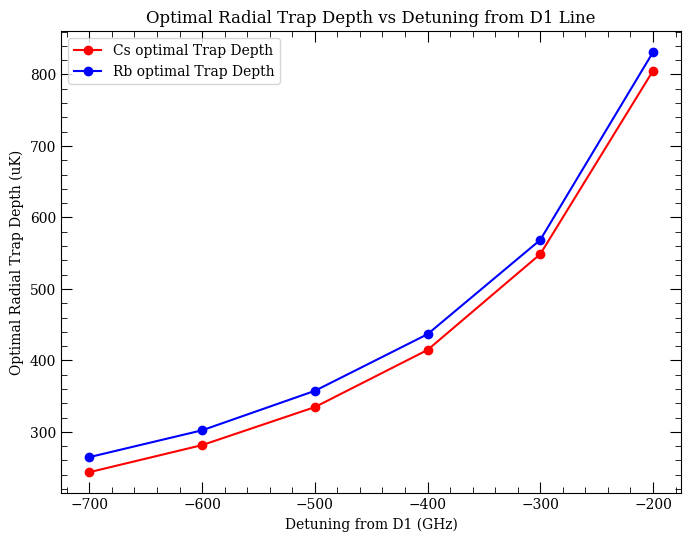

In [ ]:
# perform the same optimization as above but now sweep over the detuning from D1 line as well
detunings = np.linspace(200, 700, 6)  # detunings from D1 line in GHz
rb_data_array = []
cs_data_array = []
rb_wavelengths = []
cs_wavelengths = []
rb_polarizabilities = []
cs_polarizabilities = []
optimal_waists_Cs = []
optimal_focuses_Cs = []
optimal_waists_Rb = []
optimal_focuses_Rb = []
all_focus_arrays = []
all_waist_arrays = []
for freq in detunings:
    # set the wavelength and polarizabilities for both species
    # Cs first
    wavelength_Cs = wavelength_plus_freq_offset(Cs_D1_wavelength, -freq)  # detuned from D1
    print(f"Wavelength for Cs: {wavelength_Cs*1e9} nm")
    print(f"D1 line wavelength for Cs: {Cs_D1_wavelength*1e9} nm")
    alpha_Cs = get_polarizability(wavelength_Cs*1e9, "Cs") * a0**3  # Cs polarizability in atomic units
    print(f"Cs polarizability at {wavelength_Cs*1e9:.2f} nm: {alpha_Cs/a0**3:.2f} a0^3")
    cs_polarizabilities.append(alpha_Cs/a0**3)
    cs_wavelengths.append(wavelength_Cs*1e9)
    # convert polarizability from atomic units to SI units
    alpha_Cs_SI = alpha_Cs * 4*np.pi * epsilon_0

    # Rb next
    wavelength_Rb = wavelength_plus_freq_offset(Rb_D1_wavelength, -freq)  # detuned from D1
    print(f"Wavelength for Rb: {wavelength_Rb*1e9} nm")
    print(f"D1 line wavelength for Rb: {Rb_D1_wavelength*1e9} nm")
    alpha_Rb = get_polarizability(wavelength_Rb*1e9, "Rb") * a0**3  # Rb polarizability in atomic units
    print(f"Rb polarizability at {wavelength_Rb*1e9:.2f} nm: {alpha_Rb/a0**3:.2f} a0^3")
    rb_polarizabilities.append(alpha_Rb/a0**3)
    rb_wavelengths.append(wavelength_Rb*1e9)
    alpha_Rb_SI = alpha_Rb * 4*np.pi * epsilon_0

    # now 2D sweep of beam waist and beam focus positions
    # the start and stop of the atoms is always 0.0 and 0.372
    # the focus positions will always be symmetric around the center point 0.186
    start_pos = 0.0
    stop_pos = 0.372
    power = 1 # power per beam in Watts
    center_pos = (start_pos + stop_pos) / 2
    focus_array = np.linspace(0.0, center_pos, 500)  # focus positions from 0 to center position

    waist_array = np.linspace(100e-6, 300e-6, 500)  # beam waist from 100 to 300 microns

    # for the sweep, we find the minimum radial trap depth between the start and stop positions
    min_trap_depth_Cs = []
    min_trap_depth_Rb = []

    pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                        np.zeros(1000),  # y positions
                        np.zeros(1000))) # z positions

    for waist in waist_array:
        temp_depths_Cs = []
        temp_depths_Rb = []
        for focus in focus_array:
            # first Cs
            I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Cs)
            I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Cs)
            # calculate the radial potential
            depth_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
            min_depth_Cs = np.min(depth_Cs) # find the minimum radial trap depth

            # then Rb
            I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Rb)
            I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Rb)
            # calculate the radial potential
            depth_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
            min_depth_Rb = np.min(depth_Rb) # find the minimum radial trap depth

            temp_depths_Cs.append(min_depth_Cs)
            temp_depths_Rb.append(min_depth_Rb)

        # find the minimum trap depth
        min_trap_depth_Cs.append(temp_depths_Cs)
        min_trap_depth_Rb.append(temp_depths_Rb)

    # store data
    cs_data_array.append(min_trap_depth_Cs)
    rb_data_array.append(min_trap_depth_Rb)

    # find the optimal parameters for maximum trap depth from above data
    min_trap_depth_Cs = np.array(min_trap_depth_Cs)
    min_trap_depth_Rb = np.array(min_trap_depth_Rb)

    opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
    opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

    print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
    print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")

    optimal_waists_Cs.append(waist_array[opt_params_Cs[0]])
    optimal_focuses_Cs.append(focus_array[opt_params_Cs[1]])

    optimal_waists_Rb.append(waist_array[opt_params_Rb[0]])
    optimal_focuses_Rb.append(focus_array[opt_params_Rb[1]])
    print("--------------------------------------------------")

# convert to numpy arrays
rb_data_array = np.array(rb_data_array)
cs_data_array = np.array(cs_data_array)

# plot the maximum trap depth as a function of transport distance
max_trap_depths_Cs = [np.max(data) for data in cs_data_array]
max_trap_depths_Rb = [np.max(data) for data in rb_data_array]

plt.figure(figsize=(8, 6))
plt.plot(-1*detunings, max_trap_depths_Cs, 'r-o', label='Cs optimal Trap Depth')
plt.plot(-1*detunings, max_trap_depths_Rb, 'b-o', label='Rb optimal Trap Depth')
plt.xlabel('Detuning from D1 (GHz)')
plt.ylabel('Optimal Radial Trap Depth (uK)')
plt.title('Optimal Radial Trap Depth vs Detuning from D1 Line')
plt.legend()
plt.show()

### Now red detuned from D2 line.

Wavelength for Cs: 852.8322174507035 nm
D2 line wavelength for Cs: 852.34727582 nm
Cs polarizability at 852.83 nm: 219811.82 a0^3
Wavelength for Rb: 780.647553057811 nm
D2 line wavelength for Rb: 780.2412096859999 nm
Rb polarizability at 780.65 nm: 192152.29 a0^3
Optimal parameters for Cs: Waist = 159.72 microns, Focus = 0.0529 m, Max Trap Depth = 1642.41 uK
Optimal parameters for Rb: Waist = 153.71 microns, Focus = 0.0526 m, Max Trap Depth = 1568.47 uK
--------------------------------------------------
Wavelength for Cs: 853.074895255017 nm
D2 line wavelength for Cs: 852.34727582 nm
Cs polarizability at 853.07 nm: 146449.10 a0^3
Wavelength for Rb: 780.850883500336 nm
D2 line wavelength for Rb: 780.2412096859999 nm
Rb polarizability at 780.85 nm: 128121.62 a0^3
Optimal parameters for Cs: Waist = 158.92 microns, Focus = 0.0533 m, Max Trap Depth = 1093.96 uK
Optimal parameters for Rb: Waist = 153.71 microns, Focus = 0.0526 m, Max Trap Depth = 1045.59 uK
----------------------------------

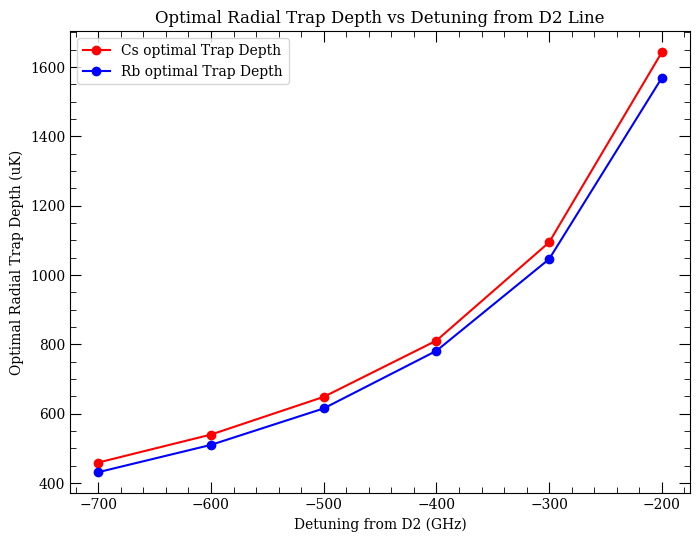

In [38]:
# perform the same optimization as above but now sweep over the detuning from D2 line as well
detunings = np.linspace(200, 700, 6)  # detunings from D2 line in GHz
rb_data_array = []
cs_data_array = []
rb_wavelengths = []
cs_wavelengths = []
rb_polarizabilities = []
cs_polarizabilities = []
optimal_waists_Cs = []
optimal_focuses_Cs = []
optimal_waists_Rb = []
optimal_focuses_Rb = []
all_focus_arrays = []
all_waist_arrays = []
for freq in detunings:
    # set the wavelength and polarizabilities for both species
    # Cs first
    wavelength_Cs = wavelength_plus_freq_offset(Cs_D2_wavelength, -freq)  # detuned from D2
    print(f"Wavelength for Cs: {wavelength_Cs*1e9} nm")
    print(f"D2 line wavelength for Cs: {Cs_D2_wavelength*1e9} nm")
    alpha_Cs = get_polarizability(wavelength_Cs*1e9, "Cs") * a0**3  # Cs polarizability in atomic units
    print(f"Cs polarizability at {wavelength_Cs*1e9:.2f} nm: {alpha_Cs/a0**3:.2f} a0^3")
    cs_polarizabilities.append(alpha_Cs/a0**3)
    cs_wavelengths.append(wavelength_Cs*1e9)
    # convert polarizability from atomic units to SI units
    alpha_Cs_SI = alpha_Cs * 4*np.pi * epsilon_0

    # Rb next
    wavelength_Rb = wavelength_plus_freq_offset(Rb_D2_wavelength, -freq)  # detuned from D2
    print(f"Wavelength for Rb: {wavelength_Rb*1e9} nm")
    print(f"D2 line wavelength for Rb: {Rb_D2_wavelength*1e9} nm")
    alpha_Rb = get_polarizability(wavelength_Rb*1e9, "Rb") * a0**3  # Rb polarizability in atomic units
    print(f"Rb polarizability at {wavelength_Rb*1e9:.2f} nm: {alpha_Rb/a0**3:.2f} a0^3")
    rb_polarizabilities.append(alpha_Rb/a0**3)
    rb_wavelengths.append(wavelength_Rb*1e9)
    alpha_Rb_SI = alpha_Rb * 4*np.pi * epsilon_0

    # now 2D sweep of beam waist and beam focus positions
    # the start and stop of the atoms is always 0.0 and 0.372
    # the focus positions will always be symmetric around the center point 0.186
    start_pos = 0.0
    stop_pos = 0.372
    power = 1 # power per beam in Watts
    center_pos = (start_pos + stop_pos) / 2
    focus_array = np.linspace(0.0, center_pos, 500)  # focus positions from 0 to center position

    waist_array = np.linspace(100e-6, 300e-6, 500)  # beam waist from 100 to 300 microns

    # for the sweep, we find the minimum radial trap depth between the start and stop positions
    min_trap_depth_Cs = []
    min_trap_depth_Rb = []

    pos_array = np.array((np.linspace(start_pos, stop_pos, 1000),   # x positions
                        np.zeros(1000),  # y positions
                        np.zeros(1000))) # z positions

    for waist in waist_array:
        temp_depths_Cs = []
        temp_depths_Rb = []
        for focus in focus_array:
            # first Cs
            I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Cs)
            I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Cs)
            # calculate the radial potential
            depth_Cs = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Cs_SI) * 1e6  # convert to uK
            min_depth_Cs = np.min(depth_Cs) # find the minimum radial trap depth

            # then Rb
            I1 = Gaussian_beam_intensity(power, waist, pos_array, focus, wavelength_Rb)
            I2 = Gaussian_beam_intensity(power, waist, pos_array, stop_pos - focus, wavelength_Rb)
            # calculate the radial potential
            depth_Rb = odt_depth(I1+I2+2*np.sqrt(I1*I2), alpha_Rb_SI) * 1e6  # convert to uK
            min_depth_Rb = np.min(depth_Rb) # find the minimum radial trap depth

            temp_depths_Cs.append(min_depth_Cs)
            temp_depths_Rb.append(min_depth_Rb)

        # find the minimum trap depth
        min_trap_depth_Cs.append(temp_depths_Cs)
        min_trap_depth_Rb.append(temp_depths_Rb)

    # store data
    cs_data_array.append(min_trap_depth_Cs)
    rb_data_array.append(min_trap_depth_Rb)

    # find the optimal parameters for maximum trap depth from above data
    min_trap_depth_Cs = np.array(min_trap_depth_Cs)
    min_trap_depth_Rb = np.array(min_trap_depth_Rb)

    opt_params_Cs = np.unravel_index(np.argmax(min_trap_depth_Cs, axis=None), min_trap_depth_Cs.shape)
    opt_params_Rb = np.unravel_index(np.argmax(min_trap_depth_Rb, axis=None), min_trap_depth_Rb.shape)

    print(f"Optimal parameters for Cs: Waist = {waist_array[opt_params_Cs[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Cs[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Cs[opt_params_Cs]:.2f} uK")
    print(f"Optimal parameters for Rb: Waist = {waist_array[opt_params_Rb[0]]*1e6:.2f} microns, Focus = {focus_array[opt_params_Rb[1]]:.4f} m, Max Trap Depth = {min_trap_depth_Rb[opt_params_Rb]:.2f} uK")

    optimal_waists_Cs.append(waist_array[opt_params_Cs[0]])
    optimal_focuses_Cs.append(focus_array[opt_params_Cs[1]])

    optimal_waists_Rb.append(waist_array[opt_params_Rb[0]])
    optimal_focuses_Rb.append(focus_array[opt_params_Rb[1]])
    print("--------------------------------------------------")

# convert to numpy arrays
rb_data_array = np.array(rb_data_array)
cs_data_array = np.array(cs_data_array)

# plot the maximum trap depth as a function of transport distance
max_trap_depths_Cs = [np.max(data) for data in cs_data_array]
max_trap_depths_Rb = [np.max(data) for data in rb_data_array]

plt.figure(figsize=(8, 6))
plt.plot(-1*detunings, max_trap_depths_Cs, 'r-o', label='Cs optimal Trap Depth')
plt.plot(-1*detunings, max_trap_depths_Rb, 'b-o', label='Rb optimal Trap Depth')
plt.xlabel('Detuning from D2 (GHz)')
plt.ylabel('Optimal Radial Trap Depth (uK)')
plt.title('Optimal Radial Trap Depth vs Detuning from D2 Line')
plt.legend()
plt.show()

## Scattering rate calculations.

In [ ]:
# function to calculate the scattering rate at a given intensity and polarizability
def scattering_rate(I, alpha):
    """
    calculate scattering rate in Hz
    polarizability in atomic units
    """
    gamma_cs = 1 / (hbar*epsilon_0*c) * alpha * I
    return gamma_sc